In [1]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import time
import sys
import gc

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# y_vocab preprocess

In [2]:
import _pickle
y_vocab = _pickle.load(open('./data_org/y_vocab.py3.cPickle', 'rb'))
y_vocab['43>109>1576>-1']
print(len(y_vocab))

token_to_cate = {}
for it in y_vocab.items():
     token_to_cate[it[1]] = it[0]

4215


In [3]:
def onehot(data_y, output_dim=4215): # 4215개
    # y-label to one-hot encoding
    y_tmp = np.zeros([len(data_y), output_dim], dtype=np.int8)
    y_tmp[np.arange(len(data_y)), data_y] = 1
    data_y = y_tmp

    return data_y

---
# char x_vocab

In [4]:
x_vocab = pd.read_csv('./data_org/char.csv', encoding='utf8')
x_vocab = x_vocab.as_matrix()

In [5]:
#  3000개 = 2998 + unk + pad
x_vocab = {
    e[0]:i  for i,e in enumerate(x_vocab[:2998])
}

In [6]:
x_vocab['<PAD>'] = 2998
x_vocab['<UNK>'] = 2999

In [7]:
len(x_vocab.values())
# x_vocab.v()
# x_vocab

3000

In [8]:
%%time
sentence = "plt.plot(x_range, val_accuracies,'-g', label='Validation'꼬ㅑ재)"
print([x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence])

[77, 19, 23, 100, 77, 19, 10, 23, 11, 162, 91, 15, 7, 22, 64, 5, 138, 0, 166, 7, 19, 91, 7, 43, 43, 57, 15, 7, 43, 13, 5, 27, 138, 614, 28, 64, 614, 138, 0, 19, 7, 120, 5, 19, 1037, 614, 121, 7, 19, 13, 58, 7, 23, 13, 10, 22, 614, 580, 2999, 292, 12]
Wall time: 1.99 ms


# word preprocess

In [9]:
def set_train_data(chunk_no):
    path_x = './tmp/data_0%d.h5'%(chunk_no)
    path_y = './tmp/data_y_0%d.csv'%(chunk_no)
    h = h5py.File(path_x, 'r')
    y = pd.read_csv(path_y, header=None, dtype=np.int32)
    y=onehot(y[0])

    # # validation data
    # path_x = './data_org/val.h5'
    # path_y = './tmp/data_y_val.csv'
    # h = h5py.File(path_x, 'r')
    # y = pd.read_csv(path_y, header=None)
    # y=onehot(y[0])

    mode = 'train'
    cols = ['pid', 'product', 'model', 'brand', 'maker', 'price', 'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
    data = {
        c: h[mode][c] for c in cols
    }
    df = pd.DataFrame(data)

    for i in ['pid', 'product', 'model', 'brand', 'maker', 'updttm']:
        df[i] = df[i].apply(lambda x: x.decode('utf8'))

    df2 = pd.DataFrame(h[mode]['img_feat'][:])
    
    h.close()
    return df, df2, y

In [10]:
# 피처 데이터, 레이블, 미니배치 갯수, random sampling
import random
import h5py
import mmh3

seq_len=128
random.seed(2018)
def getMiniBatch3(xc, xm, xe, y, n):
    assert len(xc) == len(y)
    assert len(xm) == len(y)
        
    rand_idx = random.sample(list(range(len(y))), n)    
    xc_ = xc.iloc[rand_idx] # word
    xm_ = xm.iloc[rand_idx] # image
    xe_ = xe.iloc[rand_idx] # else
    
    xe_ = np.array(xe_).transpose()[0].astype(np.int32)
    xe_ = np.array([(1,i) if not np.isnan(i) else (0,0) for i in np.log10(xe_)])
    
    y_ = y[rand_idx]
    
    # df to data - char to token
    data_x_fw = []
    data_x_bw = []
    for i in xc_.as_matrix():
        sentence = ' '.join(i)
        sentence = list(sentence)
        kkk = sentence
        # hash --> word to id
        word_ids_fw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
        word_ids_fw = np.pad(word_ids_fw, (0,seq_len-len(word_ids_fw)), 'constant', constant_values=(2998)) # pad=2998
        data_x_fw.append(word_ids_fw)
        # revcerse
        sentence.reverse()
        word_ids_bw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
        word_ids_bw = np.pad(word_ids_bw, (0,seq_len-len(word_ids_bw)), 'constant', constant_values=(2998)) # pad=2998
        data_x_bw.append(word_ids_bw)
        
        
    return np.array(data_x_fw), np.array(data_x_bw), np.array(xm_), np.array(xe_), np.array(y_)

In [11]:
%%time
X_fw, X_bw, Xm_, Xp_, Y_ = getMiniBatch3(df[['product', 'brand', 'model', 'maker']], df2,
              df[['price', 'updttm']], y, batch_size)

NameError: name 'df' is not defined

---
## set val data

In [12]:
def set_val_data():
    path_x = './tmp/data_val.h5'
    path_y = './tmp/data_y_val.csv'
    h = h5py.File(path_x, 'r')
    y = pd.read_csv(path_y, header=None, dtype=np.int32)
    y = y.sample(frac=1, random_state=2018) # shuffle y
    y = onehot(y[0])
    
    start_idx = 0 
    mode = 'val'
    cols = ['pid', 'product', 'model', 'brand', 'maker', 'price', 'updttm', 'bcateid', 'mcateid', 'scateid', 'dcateid']
    data = {
        c: h[mode][c] for c in cols
    }
    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=2018) # shuffle df

    for i in ['pid', 'product', 'model', 'brand', 'maker', 'updttm']:
        df[i] = df[i].apply(lambda x: x.decode('utf8'))

    df2 = pd.DataFrame(h[mode]['img_feat'][:])
    df2 = df2.sample(frac=1, random_state=2018) # shuffle df2
    
    h.close()
    return df, df2, y

In [13]:
#밸리데이션용으로
df_val, df2_val, Y_val_all = set_val_data()
# seq_len=100

# df to data - char to token
data_x_fw = []
data_x_bw = []
for i in tqdm(list(zip(df_val['product'], df_val['brand'], df_val['model'], df_val['maker']))):
    sentence = ' '.join(i)
    sentence = list(sentence)    
    # hash --> word to id
    word_ids_fw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
    word_ids_fw = np.pad(word_ids_fw, (0,seq_len-len(word_ids_fw)), 'constant', constant_values=(2998)) # pad=2998
    data_x_fw.append(word_ids_fw)
    # revcerse
    sentence.reverse()
    word_ids_bw = [x_vocab[k] if k in x_vocab.keys() else 2999 for k in sentence][:seq_len]
    word_ids_bw = np.pad(word_ids_bw, (0,seq_len-len(word_ids_bw)), 'constant', constant_values=(2998)) # pad=2998
    data_x_bw.append(word_ids_bw)
    
X_fw_val = np.array(data_x_fw)[:2000]
X_bw_val = np.array(data_x_bw)[:2000]
Xm_val = np.array(df2_val)[:2000]
Xp_val = np.array(df_val[['price', 'updttm']])
Xp_val = Xp_val.transpose()[0].astype(np.int32)
Xp_val = np.array([(1,i) if not np.isnan(i) else (0,0) for i in np.log10(Xp_val)])[:2000]
# Xp_val = np.expand_dims(Xp_val, axis=1)
Y_val = Y_val_all[:2000]

A Jupyter Widget

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


In [14]:
print(X_fw_val.shape, X_bw_val.shape, Xm_val.shape, Xp_val.shape, Y_val.shape)

(2000, 128) (2000, 128) (2000, 2048) (2000, 2) (2000, 4215)


# make model

In [15]:
# make DAG
tf.reset_default_graph()
tf.set_random_seed(2018)

# train Parameters
output_dim = 4215 # 1번 트레이닝셋만

epoch = 100
# seq_len=100
vocabulary_size = len(x_vocab) # x_vocab length
# embedding_size = 512
embedding_size = 256
features = 200


# =============================================================================
is_training = tf.placeholder(tf.bool) # 배치놈 위한 트레이닝/테스트 구분 불리언

Y = tf.placeholder(tf.int16, [None, output_dim], name="label")
lr = tf.placeholder(tf.float32, [], name='learning_rate')
keep_prob = tf.placeholder(tf.float32, [], name="keep_prob"
                          )

#  embedding
X_fw = tf.placeholder(tf.int32, [None, seq_len], name="word_tokens_fw") 
X_bw = tf.placeholder(tf.int32, [None, seq_len], name="word_tokens_bw") 
word_embeddings = tf.get_variable("word_embeddings",
    [vocabulary_size, embedding_size], initializer=tf.contrib.layers.xavier_initializer())
embedded_fw = tf.nn.embedding_lookup(word_embeddings, X_fw) # batch * seq * embeddding
embedded_bw = tf.nn.embedding_lookup(word_embeddings, X_bw) # batch * seq * embeddding
    
# image features
Xm = tf.placeholder(tf.float32, [None, 2048], name="img_feat") 

# price feature
Xp = tf.placeholder(tf.float32, [None, 2], name="price") 

"""
#  dropout layer
def _sequence_dropout(step_inputs, keep_prob):
        # apply dropout to each input
        # input : a list of input tensor which shape is [None, input_dim]
        with tf.name_scope('sequence_dropout') as scope:
            step_outputs = []
            for t, _input in enumerate(step_inputs):
                step_outputs.append( tf.nn.dropout(_input, keep_prob) )
        return step_outputs

embedded_fw = tf.unstack(embedded_fw, axis=1)
step_inputs = _sequence_dropout(embedded_fw, keep_prob) # seq * batch * embedding

#  FCN layer
doc_mean = tf.reduce_mean(step_inputs, axis=0) # batch * embedding (mean)
# hint = tf.placeholder(tf.float32, [None, 609], name='hint') # previous category
# bf_lenear = tf.concat([doc_mean, hint], axis=1) # batch * (embediing + hint)
# bf_lenear = tf.nn.dropout(bf_lenear, keep_prob)
"""

embedded_fw = tf.reshape(embedded_fw, [-1, seq_len, embedding_size, 1])
embedded_bw = tf.reshape(embedded_bw, [-1, seq_len, embedding_size, 1])
# CNN layer
def char_cnn(no, embedded, name):
  F = tf.get_variable(name, [no, embedding_size, 1, features], 
                     initializer=tf.contrib.layers.xavier_initializer()) # (row, column, channel, kernels)
  L = tf.nn.conv2d(embedded, F, strides=[1, 1, 1, 1], padding='VALID')
  L = tf.layers.batch_normalization(L, training=is_training)
  L = tf.nn.tanh(L)
  return L

C2f = char_cnn(2, embedded_fw, name='2gram-filter-fw') # batch, seq-1, 1, filters
C2fm = tf.nn.max_pool(C2f, ksize=[1, seq_len-(2-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C2b = char_cnn(2, embedded_bw, name='2gram-filter-bw')

C3f = char_cnn(3, embedded_fw, name='3gram-filter-fw')
C3fm = tf.nn.max_pool(C3f, ksize=[1, seq_len-(3-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C3b = char_cnn(3, embedded_bw, name='3gram-filter-bw')

C4f = char_cnn(4, embedded_fw, name='4gram-filter-fw')
C4fm = tf.nn.max_pool(C4f, ksize=[1, seq_len-(4-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
C4b = char_cnn(4, embedded_bw, name='4gram-filter-bw')

# C5f = char_cnn(5, embedded_fw, name='5gram-filter-fw')
# C5fm = tf.nn.max_pool(C5f, ksize=[1, seq_len-(5-1), 1, 1], strides=[1, 1, 1, 1], padding='VALID')
# C5b = char_cnn(5, embedded_bw, name='5gram-filter-bw')

# 1*1 conv
def one_cnn(fw, bw, name):
    Concat = tf.concat([fw, bw], 3)
    F = tf.get_variable(name, [1, 1, 2*features, 1], 
                     initializer=tf.contrib.layers.xavier_initializer()) # (row, column, channel, kernels)
    L = tf.nn.conv2d(Concat, F, strides=[1, 1, 1, 1], padding='VALID')
    L = tf.layers.batch_normalization(L, training=is_training)
    L = tf.nn.tanh(L)
    return L

C2all = one_cnn(C2f, C2b, '2gram-1by1-filter')
C3all = one_cnn(C3f, C3b, '3gram-1by1-filter')
C4all = one_cnn(C4f, C4b, '4gram-1by1-filter')
C_all = tf.concat([C2all, C3all, C4all], 1)
C_all = tf.squeeze(C_all, axis=[2,3]) # (?, seq_len*3 - some)

conv_list = [C2fm, C3fm, C4fm]
C_cat = tf.concat(conv_list, 3) # (?, 1, 1, features*3) --> to attention
C_flat = tf.reshape(C_cat, [-1, len(conv_list)*features]) # (?, features*3)
C_flat = tf.contrib.layers.fully_connected(C_flat, len(conv_list)*50, activation_fn=tf.nn.elu) #(?, 50*3)

# 이미지
# Xm = tf.nn.dropout(Xm, keep_prob)
Xm2 = tf.contrib.layers.fully_connected(Xm, features, activation_fn=tf.nn.elu) # (?, features*3)

# dot product attention
Xm2_3d = tf.reshape(Xm2, [-1, features, 1])
C_cat_3d = tf.reshape(C_cat, [-1, len(conv_list), features])
A = tf.matmul(C_cat_3d, Xm2_3d) # ?, 3, 1
A_soft = tf.nn.softmax(A, axis=1)
ww = A_soft*C_cat_3d # ?, 3, 200
att = tf.reduce_sum(ww, axis=1) # ?, 200

C_flat_final = tf.concat([C_flat, C_all, att, Xm2, Xp], axis=1)

# 오캄의 면도날... 굳이 없어도 되는 레이어인듯
# L_linear = tf.contrib.layers.fully_connected(C_flat_final, 512, activation_fn=tf.nn.relu)
# L_linear = tf.nn.dropout(L_linear, keep_prob)
L_linear = tf.nn.dropout(C_flat_final, keep_prob)


# Y_pred = tf.contrib.layers.fully_connected(bf_lenear, output_dim, activation_fn=tf.nn.relu)  # We use the last cell's output
L_linear2 = tf.contrib.layers.fully_connected(L_linear, 1024, activation_fn=tf.nn.elu)  # We use the last cell's output
Y_pred = tf.contrib.layers.fully_connected(L_linear2, output_dim, activation_fn=None)  # We use the last cell's output


# # image feature
# X = tf.placeholder(tf.float32, [None, len(data_x[0])], name="img_feat")
# X = tf.nn.dropout(X, keep_prob)
# Y_pred = tf.contrib.layers.fully_connected(X, output_dim,
#                                            activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())  # We use the last cell's output

# for batch norm
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# optimize
cost =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=Y_pred, labels=Y, name='cross_entropy'))
optimizer = tf.train.AdamOptimizer(lr)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(cost)

# prediction
predicted = tf.argmax(Y_pred, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, tf.argmax(Y, 1)), dtype=tf.float32))

# saver
name_to_var_map = {var.op.name: var for var in tf.global_variables()}
saver = tf.train.Saver(name_to_var_map, name='my_saver', max_to_keep=30)

# train/save

In [17]:
%%time 
gc.collect()

# if 'sess' in globals(): sess.close()
# sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
# sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
val_costs=[]
ckpt_path = './small_model/small'
# lr_start = 0.005
lr_start = 0.000324194
batch_size = 1024
# iter_per_epoch = int(len(Y_train)/batch_size)
iter_per_epoch = int(812650/batch_size)

chunk_no = 0
chunk_no_pre = -1

start = time.time()
print('total iter is %d * %d' %(epoch, iter_per_epoch))
for e in range(epoch):
# 데이터 청크 같으면 다시 로드 안하는 코드 넣기, 청크 순서도 고려해보기
    # epoch별 데이터 청크 로드
#     chunk_no = int((e+6)/2)%10  # int((e + shift_epoch*2)/2)%chunk_range+1
    chunk_no = int(e/2)%10
    if chunk_no!=chunk_no_pre:
        df, df2, y = set_train_data(chunk_no)
        gc.collect()
    chunk_no_pre = chunk_no
    
    print('********** %d epoch started: lr-%g, chunk_no-%d **********'%(e, lr_start, chunk_no))
    for i in range(iter_per_epoch):
        X_fw_, X_bw_, Xm_, Xp_, Y_ = getMiniBatch3(df[['product', 'brand', 'model', 'maker']], df2,
                      df[['price', 'updttm']], y, batch_size)
        train_step.run(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:True})

    #   아래에 결과 프린트용
        if i % 50 == 0:   
            train_accuracy = accuracy.eval(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:False})
            val_accuracy, val_cost = sess.run([accuracy, cost], feed_dict={X_fw:X_fw_val, X_bw:X_bw_val, Xm:Xm_val, Xp:Xp_val, Y:Y_val, keep_prob:1, is_training:False})

            if lr_start>0.005: lr_start = lr_start*0.94
            elif lr_start>0.0005: lr_start = lr_start*0.998 # lr annealing
            else :lr_start = lr_start*0.999
            
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_costs.append(val_cost)
            x_range.append(i+ iter_per_epoch*e)
            end = time.time()
            print('step %d: acc_tr %.5f, acc_val %.5f, cost_val %.5f, \t//%.3f sec' % (i, train_accuracy, val_accuracy, val_cost, end-start))
            start = time.time()
            
    saver.save(sess, ckpt_path, global_step=i+ iter_per_epoch*e)
    print('model saved: %s-%d'%(ckpt_path, i+ iter_per_epoch*e))

total iter is 100 * 793
********** 0 epoch started: lr-0.000324194, chunk_no-0 **********


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


step 0: acc_tr 0.65625, acc_val 0.66850, cost_val 1.34351, 	//31.768 sec
step 50: acc_tr 0.68164, acc_val 0.68000, cost_val 1.33811, 	//27.204 sec
step 100: acc_tr 0.68359, acc_val 0.67150, cost_val 1.35857, 	//28.023 sec
step 150: acc_tr 0.68262, acc_val 0.67150, cost_val 1.36701, 	//27.495 sec
step 200: acc_tr 0.66797, acc_val 0.66650, cost_val 1.35319, 	//27.863 sec
step 250: acc_tr 0.68945, acc_val 0.67350, cost_val 1.35347, 	//27.192 sec
step 300: acc_tr 0.69336, acc_val 0.67000, cost_val 1.36519, 	//28.131 sec
step 350: acc_tr 0.68262, acc_val 0.66650, cost_val 1.38245, 	//27.120 sec
step 400: acc_tr 0.69922, acc_val 0.66950, cost_val 1.36424, 	//28.265 sec
step 450: acc_tr 0.68945, acc_val 0.66300, cost_val 1.37876, 	//27.697 sec
step 500: acc_tr 0.65820, acc_val 0.67200, cost_val 1.35659, 	//28.005 sec
step 550: acc_tr 0.68652, acc_val 0.66850, cost_val 1.38670, 	//27.454 sec
step 600: acc_tr 0.67480, acc_val 0.67100, cost_val 1.35711, 	//28.251 sec
step 650: acc_tr 0.69043, ac

step 250: acc_tr 0.68848, acc_val 0.66900, cost_val 1.33057, 	//28.277 sec
step 300: acc_tr 0.64746, acc_val 0.67050, cost_val 1.34919, 	//27.452 sec
step 350: acc_tr 0.68652, acc_val 0.67650, cost_val 1.33363, 	//27.889 sec
step 400: acc_tr 0.66797, acc_val 0.66650, cost_val 1.35000, 	//27.327 sec
step 450: acc_tr 0.69238, acc_val 0.67500, cost_val 1.32723, 	//28.248 sec
step 500: acc_tr 0.69629, acc_val 0.67500, cost_val 1.33742, 	//27.716 sec
step 550: acc_tr 0.68848, acc_val 0.66650, cost_val 1.33814, 	//28.235 sec
step 600: acc_tr 0.69141, acc_val 0.66800, cost_val 1.33491, 	//27.163 sec
step 650: acc_tr 0.70215, acc_val 0.66200, cost_val 1.34039, 	//28.383 sec
step 700: acc_tr 0.69531, acc_val 0.67250, cost_val 1.32898, 	//27.342 sec
step 750: acc_tr 0.68750, acc_val 0.67750, cost_val 1.32319, 	//27.928 sec
model saved: ./small_model/small-5550
********** 7 epoch started: lr-0.000289828, chunk_no-3 **********
step 0: acc_tr 0.68262, acc_val 0.66600, cost_val 1.34833, 	//24.947 se

step 500: acc_tr 0.66797, acc_val 0.67650, cost_val 1.31997, 	//27.159 sec
step 550: acc_tr 0.68555, acc_val 0.67550, cost_val 1.31674, 	//27.748 sec
step 600: acc_tr 0.68262, acc_val 0.67400, cost_val 1.34004, 	//27.082 sec
step 650: acc_tr 0.68750, acc_val 0.67250, cost_val 1.32436, 	//28.148 sec
step 700: acc_tr 0.69336, acc_val 0.68000, cost_val 1.30964, 	//27.126 sec
step 750: acc_tr 0.70605, acc_val 0.66900, cost_val 1.32532, 	//27.767 sec
model saved: ./small_model/small-10308
********** 13 epoch started: lr-0.000263285, chunk_no-6 **********
step 0: acc_tr 0.67285, acc_val 0.67450, cost_val 1.32877, 	//24.966 sec
step 50: acc_tr 0.67578, acc_val 0.67950, cost_val 1.32531, 	//27.203 sec
step 100: acc_tr 0.68945, acc_val 0.67250, cost_val 1.32116, 	//28.051 sec
step 150: acc_tr 0.69727, acc_val 0.66950, cost_val 1.32840, 	//27.203 sec
step 200: acc_tr 0.71875, acc_val 0.67250, cost_val 1.32126, 	//27.824 sec
step 250: acc_tr 0.68750, acc_val 0.67650, cost_val 1.33367, 	//27.537 s

step 750: acc_tr 0.67969, acc_val 0.67600, cost_val 1.30613, 	//27.816 sec
model saved: ./small_model/small-15066
********** 19 epoch started: lr-0.000239174, chunk_no-9 **********
step 0: acc_tr 0.69141, acc_val 0.67550, cost_val 1.31377, 	//24.981 sec
step 50: acc_tr 0.68359, acc_val 0.68150, cost_val 1.29027, 	//27.079 sec
step 100: acc_tr 0.68848, acc_val 0.67200, cost_val 1.31333, 	//27.719 sec
step 150: acc_tr 0.70703, acc_val 0.67950, cost_val 1.31304, 	//27.077 sec
step 200: acc_tr 0.68066, acc_val 0.67650, cost_val 1.30899, 	//27.692 sec
step 250: acc_tr 0.68848, acc_val 0.67200, cost_val 1.31779, 	//27.497 sec
step 300: acc_tr 0.69336, acc_val 0.67850, cost_val 1.29249, 	//27.722 sec
step 350: acc_tr 0.72070, acc_val 0.67550, cost_val 1.29220, 	//27.102 sec
step 400: acc_tr 0.67188, acc_val 0.67900, cost_val 1.29855, 	//27.902 sec
step 450: acc_tr 0.70996, acc_val 0.67400, cost_val 1.30826, 	//27.274 sec
step 500: acc_tr 0.67188, acc_val 0.67750, cost_val 1.30843, 	//28.093 s

step 100: acc_tr 0.72168, acc_val 0.67150, cost_val 1.32112, 	//27.805 sec
step 150: acc_tr 0.70117, acc_val 0.68100, cost_val 1.31267, 	//27.204 sec
step 200: acc_tr 0.69531, acc_val 0.66900, cost_val 1.31286, 	//27.838 sec
step 250: acc_tr 0.71191, acc_val 0.68500, cost_val 1.29935, 	//27.523 sec
step 300: acc_tr 0.69629, acc_val 0.67750, cost_val 1.31220, 	//27.835 sec
step 350: acc_tr 0.67969, acc_val 0.67800, cost_val 1.30565, 	//27.248 sec
step 400: acc_tr 0.72656, acc_val 0.67600, cost_val 1.31467, 	//27.828 sec
step 450: acc_tr 0.71289, acc_val 0.67800, cost_val 1.31962, 	//27.182 sec
step 500: acc_tr 0.69531, acc_val 0.68150, cost_val 1.32037, 	//28.131 sec
step 550: acc_tr 0.70215, acc_val 0.67600, cost_val 1.30791, 	//27.188 sec
step 600: acc_tr 0.71680, acc_val 0.67600, cost_val 1.31643, 	//27.797 sec
step 650: acc_tr 0.71191, acc_val 0.67750, cost_val 1.32856, 	//27.203 sec
step 700: acc_tr 0.68652, acc_val 0.68100, cost_val 1.30068, 	//27.718 sec
step 750: acc_tr 0.68848,

step 350: acc_tr 0.72461, acc_val 0.68300, cost_val 1.29478, 	//27.074 sec
step 400: acc_tr 0.69336, acc_val 0.68550, cost_val 1.28293, 	//27.734 sec
step 450: acc_tr 0.71094, acc_val 0.67450, cost_val 1.28613, 	//27.118 sec
step 500: acc_tr 0.69141, acc_val 0.67300, cost_val 1.30392, 	//28.130 sec
step 550: acc_tr 0.69043, acc_val 0.67400, cost_val 1.29616, 	//27.118 sec
step 600: acc_tr 0.70605, acc_val 0.68250, cost_val 1.28328, 	//27.905 sec
step 650: acc_tr 0.69824, acc_val 0.68050, cost_val 1.29342, 	//27.189 sec
step 700: acc_tr 0.71777, acc_val 0.67500, cost_val 1.28857, 	//27.902 sec
step 750: acc_tr 0.70215, acc_val 0.68250, cost_val 1.29639, 	//27.645 sec
model saved: ./small_model/small-25375
********** 32 epoch started: lr-0.000194238, chunk_no-6 **********
step 0: acc_tr 0.71582, acc_val 0.67600, cost_val 1.30033, 	//55.477 sec
step 50: acc_tr 0.67969, acc_val 0.68100, cost_val 1.28509, 	//26.787 sec
step 100: acc_tr 0.71582, acc_val 0.68050, cost_val 1.30125, 	//27.120 s

step 600: acc_tr 0.69531, acc_val 0.67800, cost_val 1.27467, 	//27.817 sec
step 650: acc_tr 0.66992, acc_val 0.68650, cost_val 1.27964, 	//27.222 sec
step 700: acc_tr 0.69629, acc_val 0.68150, cost_val 1.25894, 	//27.796 sec
step 750: acc_tr 0.68457, acc_val 0.68600, cost_val 1.25968, 	//27.505 sec
model saved: ./small_model/small-30133
********** 38 epoch started: lr-0.00017645, chunk_no-9 **********
step 0: acc_tr 0.64453, acc_val 0.68600, cost_val 1.26294, 	//54.581 sec
step 50: acc_tr 0.66992, acc_val 0.69600, cost_val 1.26040, 	//26.828 sec
step 100: acc_tr 0.68066, acc_val 0.68900, cost_val 1.26225, 	//26.968 sec
step 150: acc_tr 0.68457, acc_val 0.68700, cost_val 1.24798, 	//28.095 sec
step 200: acc_tr 0.67969, acc_val 0.68450, cost_val 1.27021, 	//27.048 sec
step 250: acc_tr 0.68848, acc_val 0.67950, cost_val 1.26935, 	//27.766 sec
step 300: acc_tr 0.67188, acc_val 0.68300, cost_val 1.27134, 	//27.126 sec
step 350: acc_tr 0.66504, acc_val 0.68000, cost_val 1.27757, 	//27.781 se

********** 44 epoch started: lr-0.000160291, chunk_no-2 **********
step 0: acc_tr 0.70020, acc_val 0.67700, cost_val 1.28629, 	//55.154 sec
step 50: acc_tr 0.68066, acc_val 0.67500, cost_val 1.29076, 	//27.046 sec
step 100: acc_tr 0.69629, acc_val 0.68000, cost_val 1.26921, 	//27.064 sec
step 150: acc_tr 0.67773, acc_val 0.68500, cost_val 1.26989, 	//28.095 sec
step 200: acc_tr 0.69141, acc_val 0.67500, cost_val 1.27829, 	//27.088 sec
step 250: acc_tr 0.71191, acc_val 0.68700, cost_val 1.27956, 	//27.749 sec
step 300: acc_tr 0.71484, acc_val 0.67550, cost_val 1.28712, 	//27.112 sec
step 350: acc_tr 0.71191, acc_val 0.68500, cost_val 1.27616, 	//27.780 sec
step 400: acc_tr 0.70801, acc_val 0.68450, cost_val 1.27783, 	//27.491 sec
step 450: acc_tr 0.70410, acc_val 0.67950, cost_val 1.29675, 	//27.750 sec
step 500: acc_tr 0.69043, acc_val 0.67950, cost_val 1.28229, 	//27.136 sec
step 550: acc_tr 0.69043, acc_val 0.68250, cost_val 1.28283, 	//27.970 sec
step 600: acc_tr 0.70508, acc_val 0.

step 200: acc_tr 0.68457, acc_val 0.67850, cost_val 1.28399, 	//27.709 sec
step 250: acc_tr 0.69824, acc_val 0.67200, cost_val 1.29170, 	//27.149 sec
step 300: acc_tr 0.70898, acc_val 0.69500, cost_val 1.28401, 	//27.778 sec
step 350: acc_tr 0.71875, acc_val 0.68250, cost_val 1.28591, 	//27.228 sec
step 400: acc_tr 0.70215, acc_val 0.68000, cost_val 1.27119, 	//28.104 sec
step 450: acc_tr 0.70312, acc_val 0.68150, cost_val 1.27161, 	//27.138 sec
step 500: acc_tr 0.70117, acc_val 0.68300, cost_val 1.28454, 	//27.811 sec
step 550: acc_tr 0.70410, acc_val 0.68600, cost_val 1.28583, 	//27.203 sec
step 600: acc_tr 0.69141, acc_val 0.68050, cost_val 1.27262, 	//28.173 sec
step 650: acc_tr 0.69434, acc_val 0.68050, cost_val 1.26876, 	//27.178 sec
step 700: acc_tr 0.68457, acc_val 0.68400, cost_val 1.26247, 	//27.842 sec
step 750: acc_tr 0.70703, acc_val 0.68200, cost_val 1.27774, 	//27.166 sec
model saved: ./small_model/small-40442
********** 51 epoch started: lr-0.000143299, chunk_no-5 *****

step 450: acc_tr 0.69727, acc_val 0.67400, cost_val 1.26933, 	//27.757 sec
step 500: acc_tr 0.69434, acc_val 0.68250, cost_val 1.25476, 	//27.094 sec
step 550: acc_tr 0.69043, acc_val 0.69350, cost_val 1.25094, 	//27.731 sec
step 600: acc_tr 0.68848, acc_val 0.68800, cost_val 1.26466, 	//27.109 sec
step 650: acc_tr 0.70215, acc_val 0.68250, cost_val 1.26888, 	//28.093 sec
step 700: acc_tr 0.69336, acc_val 0.68750, cost_val 1.24929, 	//27.232 sec
step 750: acc_tr 0.69531, acc_val 0.68850, cost_val 1.25636, 	//27.833 sec
model saved: ./small_model/small-45200
********** 57 epoch started: lr-0.000130176, chunk_no-8 **********
step 0: acc_tr 0.69434, acc_val 0.68800, cost_val 1.24192, 	//25.011 sec
step 50: acc_tr 0.66992, acc_val 0.68400, cost_val 1.25203, 	//27.080 sec
step 100: acc_tr 0.68945, acc_val 0.69200, cost_val 1.24558, 	//27.736 sec
step 150: acc_tr 0.67383, acc_val 0.68100, cost_val 1.26307, 	//27.081 sec
step 200: acc_tr 0.71094, acc_val 0.69200, cost_val 1.25723, 	//27.704 s

step 700: acc_tr 0.70215, acc_val 0.68900, cost_val 1.26325, 	//27.144 sec
step 750: acc_tr 0.71582, acc_val 0.68750, cost_val 1.26161, 	//27.809 sec
model saved: ./small_model/small-49958
********** 63 epoch started: lr-0.000118254, chunk_no-1 **********
step 0: acc_tr 0.70312, acc_val 0.68650, cost_val 1.27403, 	//25.018 sec
step 50: acc_tr 0.70312, acc_val 0.69650, cost_val 1.25772, 	//27.162 sec
step 100: acc_tr 0.72754, acc_val 0.68650, cost_val 1.27252, 	//27.827 sec
step 150: acc_tr 0.70410, acc_val 0.68350, cost_val 1.27047, 	//27.214 sec
step 200: acc_tr 0.72266, acc_val 0.68800, cost_val 1.26560, 	//27.773 sec
step 250: acc_tr 0.69531, acc_val 0.68650, cost_val 1.26873, 	//27.492 sec
step 300: acc_tr 0.67773, acc_val 0.67950, cost_val 1.27258, 	//27.801 sec
step 350: acc_tr 0.67773, acc_val 0.68700, cost_val 1.27327, 	//27.139 sec
step 400: acc_tr 0.71680, acc_val 0.68250, cost_val 1.27276, 	//27.797 sec
step 450: acc_tr 0.71973, acc_val 0.68350, cost_val 1.27109, 	//27.302 s

step 50: acc_tr 0.67871, acc_val 0.68300, cost_val 1.26689, 	//27.263 sec
step 100: acc_tr 0.69434, acc_val 0.68300, cost_val 1.26352, 	//28.280 sec
step 150: acc_tr 0.68750, acc_val 0.68550, cost_val 1.26730, 	//27.556 sec
step 200: acc_tr 0.71289, acc_val 0.68850, cost_val 1.25549, 	//27.897 sec
step 250: acc_tr 0.72461, acc_val 0.68900, cost_val 1.25834, 	//28.231 sec
step 300: acc_tr 0.70020, acc_val 0.68550, cost_val 1.25547, 	//28.158 sec
step 350: acc_tr 0.71582, acc_val 0.68400, cost_val 1.27077, 	//27.416 sec
step 400: acc_tr 0.70312, acc_val 0.68850, cost_val 1.25939, 	//28.047 sec
step 450: acc_tr 0.71582, acc_val 0.68500, cost_val 1.25923, 	//27.273 sec
step 500: acc_tr 0.68652, acc_val 0.69150, cost_val 1.25635, 	//28.290 sec
step 550: acc_tr 0.71875, acc_val 0.69100, cost_val 1.26366, 	//27.326 sec
step 600: acc_tr 0.69824, acc_val 0.69000, cost_val 1.25641, 	//27.788 sec
step 650: acc_tr 0.71484, acc_val 0.68550, cost_val 1.25996, 	//27.383 sec
step 700: acc_tr 0.70215, 

step 300: acc_tr 0.67480, acc_val 0.68600, cost_val 1.24808, 	//27.745 sec
step 350: acc_tr 0.71484, acc_val 0.68550, cost_val 1.24848, 	//27.112 sec
step 400: acc_tr 0.71680, acc_val 0.69300, cost_val 1.24464, 	//27.737 sec
step 450: acc_tr 0.70020, acc_val 0.68900, cost_val 1.23809, 	//27.124 sec
step 500: acc_tr 0.69434, acc_val 0.68550, cost_val 1.24736, 	//28.652 sec
step 550: acc_tr 0.71094, acc_val 0.68550, cost_val 1.25505, 	//27.794 sec
step 600: acc_tr 0.68848, acc_val 0.68300, cost_val 1.25739, 	//28.205 sec
step 650: acc_tr 0.69531, acc_val 0.69100, cost_val 1.24310, 	//27.328 sec
step 700: acc_tr 0.71680, acc_val 0.68800, cost_val 1.25310, 	//27.885 sec
step 750: acc_tr 0.69238, acc_val 0.68900, cost_val 1.24512, 	//27.497 sec
model saved: ./small_model/small-60267
********** 76 epoch started: lr-9.6037e-05, chunk_no-8 **********
step 0: acc_tr 0.71191, acc_val 0.69150, cost_val 1.24754, 	//55.270 sec
step 50: acc_tr 0.71582, acc_val 0.69150, cost_val 1.24644, 	//27.055 se

step 550: acc_tr 0.69922, acc_val 0.69050, cost_val 1.25487, 	//27.437 sec
step 600: acc_tr 0.73828, acc_val 0.68950, cost_val 1.25123, 	//28.105 sec
step 650: acc_tr 0.67383, acc_val 0.69300, cost_val 1.25172, 	//26.990 sec
step 700: acc_tr 0.70801, acc_val 0.68700, cost_val 1.24655, 	//27.893 sec
step 750: acc_tr 0.71289, acc_val 0.69400, cost_val 1.24156, 	//27.666 sec
model saved: ./small_model/small-65025
********** 82 epoch started: lr-8.7242e-05, chunk_no-1 **********
step 0: acc_tr 0.70801, acc_val 0.69300, cost_val 1.24672, 	//55.495 sec
step 50: acc_tr 0.68652, acc_val 0.69000, cost_val 1.24681, 	//27.513 sec
step 100: acc_tr 0.70215, acc_val 0.68950, cost_val 1.25117, 	//27.233 sec
step 150: acc_tr 0.68164, acc_val 0.68550, cost_val 1.25354, 	//28.142 sec
step 200: acc_tr 0.68359, acc_val 0.68800, cost_val 1.24880, 	//27.186 sec
step 250: acc_tr 0.69824, acc_val 0.69000, cost_val 1.25305, 	//27.802 sec
step 300: acc_tr 0.73242, acc_val 0.69400, cost_val 1.24099, 	//27.125 se

model saved: ./small_model/small-69783
********** 88 epoch started: lr-7.92524e-05, chunk_no-4 **********
step 0: acc_tr 0.69238, acc_val 0.68600, cost_val 1.23065, 	//54.837 sec
step 50: acc_tr 0.70312, acc_val 0.68850, cost_val 1.25282, 	//26.918 sec
step 100: acc_tr 0.68359, acc_val 0.68850, cost_val 1.24424, 	//27.739 sec
step 150: acc_tr 0.68652, acc_val 0.68500, cost_val 1.24309, 	//27.613 sec
step 200: acc_tr 0.66895, acc_val 0.68750, cost_val 1.24430, 	//27.816 sec
step 250: acc_tr 0.70312, acc_val 0.69350, cost_val 1.24720, 	//27.170 sec
step 300: acc_tr 0.71094, acc_val 0.69000, cost_val 1.25364, 	//27.913 sec
step 350: acc_tr 0.73438, acc_val 0.69300, cost_val 1.25055, 	//27.155 sec
step 400: acc_tr 0.71484, acc_val 0.69300, cost_val 1.24866, 	//28.097 sec
step 450: acc_tr 0.71094, acc_val 0.69150, cost_val 1.24571, 	//27.107 sec
step 500: acc_tr 0.67676, acc_val 0.69250, cost_val 1.24104, 	//27.923 sec
step 550: acc_tr 0.73145, acc_val 0.69000, cost_val 1.24725, 	//27.187 s

KeyboardInterrupt: 

In [46]:
%%time 
gc.collect()

# if 'sess' in globals(): sess.close()
# sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
# sess.run(tf.global_variables_initializer())

x_range=[]
train_accuracies=[]
val_accuracies=[]
val_costs=[]
ckpt_path = './small_model/small'
# lr_start = 0.005
lr_start = 0.000324194
batch_size = 1024
# iter_per_epoch = int(len(Y_train)/batch_size)
iter_per_epoch = int(812650/batch_size)

chunk_no = 0
chunk_no_pre = -1

start = time.time()
print('total iter is %d * %d' %(epoch, iter_per_epoch))
for e in range(epoch):
# 데이터 청크 같으면 다시 로드 안하는 코드 넣기, 청크 순서도 고려해보기
    # epoch별 데이터 청크 로드
#     chunk_no = int((e+6)/2)%10  # int((e + shift_epoch*2)/2)%chunk_range+1
    chunk_no = int(e/2)%10
    if chunk_no!=chunk_no_pre:
        df, df2, y = set_train_data(chunk_no)
        gc.collect()
    chunk_no_pre = chunk_no
    
    print('********** %d epoch started: lr-%g, chunk_no-%d **********'%(e, lr_start, chunk_no))
    for i in range(iter_per_epoch):
        X_fw_, X_bw_, Xm_, Xp_, Y_ = getMiniBatch3(df[['product', 'brand', 'model', 'maker']], df2,
                      df[['price', 'updttm']], y, batch_size)
        train_step.run(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:True})

    #   아래에 결과 프린트용
        if i % 50 == 0:   
            train_accuracy = accuracy.eval(feed_dict={X_fw:X_fw_, X_bw:X_bw_, Xm:Xm_, Xp:Xp_, Y:Y_, lr:lr_start, keep_prob:0.5, is_training:False})
            val_accuracy, val_cost = sess.run([accuracy, cost], feed_dict={X_fw:X_fw_val, X_bw:X_bw_val, Xm:Xm_val, Xp:Xp_val, Y:Y_val, keep_prob:1, is_training:False})

            if lr_start>0.005: lr_start = lr_start*0.94
            elif lr_start>0.0005: lr_start = lr_start*0.998 # lr annealing
            else :lr_start = lr_start*0.999
            
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            val_costs.append(val_cost)
            x_range.append(i+ iter_per_epoch*e)
            end = time.time()
            print('step %d: acc_tr %.5f, acc_val %.5f, cost_val %.5f, \t//%.3f sec' % (i, train_accuracy, val_accuracy, val_cost, end-start))
            start = time.time()
            
    saver.save(sess, ckpt_path, global_step=i+ iter_per_epoch*e)
    print('model saved: %s-%d'%(ckpt_path, i+ iter_per_epoch*e))

total iter is 100 * 793
********** 0 epoch started: lr-0.008, chunk_no-0 **********


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


step 0: acc_tr 0.00977, acc_val 0.00450, cost_val 8.49656, 	//19.004 sec
step 50: acc_tr 0.02051, acc_val 0.01100, cost_val 9.69483, 	//27.291 sec
step 100: acc_tr 0.05664, acc_val 0.05500, cost_val 7.82277, 	//28.015 sec
step 150: acc_tr 0.06543, acc_val 0.06100, cost_val 7.15373, 	//27.466 sec
step 200: acc_tr 0.08887, acc_val 0.08400, cost_val 6.56280, 	//27.976 sec
step 250: acc_tr 0.10059, acc_val 0.10350, cost_val 6.13702, 	//27.166 sec
step 300: acc_tr 0.14062, acc_val 0.11400, cost_val 5.99451, 	//27.914 sec
step 350: acc_tr 0.14746, acc_val 0.13650, cost_val 5.79197, 	//27.296 sec
step 400: acc_tr 0.16699, acc_val 0.16400, cost_val 5.56242, 	//28.221 sec
step 450: acc_tr 0.17090, acc_val 0.17250, cost_val 5.46717, 	//27.230 sec
step 500: acc_tr 0.21973, acc_val 0.20350, cost_val 5.15095, 	//27.923 sec
step 550: acc_tr 0.25586, acc_val 0.20550, cost_val 4.95821, 	//27.164 sec
step 600: acc_tr 0.22754, acc_val 0.22650, cost_val 4.85071, 	//28.094 sec
step 650: acc_tr 0.26855, ac

step 500: acc_tr 0.52832, acc_val 0.52800, cost_val 2.73413, 	//27.129 sec
step 550: acc_tr 0.55566, acc_val 0.53400, cost_val 2.84222, 	//27.843 sec
step 600: acc_tr 0.55273, acc_val 0.51700, cost_val 2.82151, 	//27.182 sec
step 650: acc_tr 0.54492, acc_val 0.53100, cost_val 2.85348, 	//28.130 sec
step 700: acc_tr 0.57520, acc_val 0.54050, cost_val 2.77595, 	//27.162 sec
step 750: acc_tr 0.54688, acc_val 0.53550, cost_val 2.70865, 	//27.868 sec
model saved: ./small_model/small-10308
********** 13 epoch started: lr-0.00314632, chunk_no-6 **********
step 0: acc_tr 0.54980, acc_val 0.53150, cost_val 2.69495, 	//25.069 sec
step 50: acc_tr 0.51074, acc_val 0.52850, cost_val 2.75760, 	//27.138 sec
step 100: acc_tr 0.53516, acc_val 0.53700, cost_val 2.75476, 	//27.719 sec
step 150: acc_tr 0.54785, acc_val 0.52700, cost_val 2.87181, 	//27.192 sec
step 200: acc_tr 0.55859, acc_val 0.53300, cost_val 2.72249, 	//27.826 sec
step 250: acc_tr 0.52832, acc_val 0.53450, cost_val 2.63436, 	//27.512 se

step 100: acc_tr 0.58789, acc_val 0.56700, cost_val 2.12481, 	//28.060 sec
step 150: acc_tr 0.60156, acc_val 0.57400, cost_val 2.09736, 	//27.504 sec
step 200: acc_tr 0.61133, acc_val 0.56700, cost_val 2.20578, 	//28.144 sec
step 250: acc_tr 0.56055, acc_val 0.57250, cost_val 2.25735, 	//27.592 sec
step 300: acc_tr 0.61133, acc_val 0.58150, cost_val 2.13322, 	//27.846 sec
step 350: acc_tr 0.58496, acc_val 0.57400, cost_val 2.20131, 	//27.398 sec
step 400: acc_tr 0.62402, acc_val 0.57700, cost_val 2.12305, 	//28.006 sec
step 450: acc_tr 0.60352, acc_val 0.57400, cost_val 2.17644, 	//27.408 sec
step 500: acc_tr 0.59961, acc_val 0.57200, cost_val 2.21362, 	//28.238 sec
step 550: acc_tr 0.58594, acc_val 0.56200, cost_val 2.21191, 	//27.130 sec
step 600: acc_tr 0.61914, acc_val 0.57900, cost_val 2.17567, 	//27.768 sec
step 650: acc_tr 0.58203, acc_val 0.58650, cost_val 2.18166, 	//27.223 sec
step 700: acc_tr 0.58496, acc_val 0.58550, cost_val 2.09863, 	//27.854 sec
step 750: acc_tr 0.63086,

step 600: acc_tr 0.62500, acc_val 0.61200, cost_val 1.78691, 	//27.794 sec
step 650: acc_tr 0.61426, acc_val 0.60300, cost_val 1.80102, 	//27.170 sec
step 700: acc_tr 0.63086, acc_val 0.60800, cost_val 1.77922, 	//27.615 sec
step 750: acc_tr 0.63086, acc_val 0.62300, cost_val 1.76061, 	//27.342 sec
model saved: ./small_model/small-30133
********** 38 epoch started: lr-0.0014126, chunk_no-9 **********
step 0: acc_tr 0.59668, acc_val 0.61950, cost_val 1.71033, 	//55.041 sec
step 50: acc_tr 0.60254, acc_val 0.60050, cost_val 1.80885, 	//26.913 sec
step 100: acc_tr 0.60840, acc_val 0.60800, cost_val 1.77300, 	//27.599 sec
step 150: acc_tr 0.61816, acc_val 0.61550, cost_val 1.75227, 	//27.463 sec
step 200: acc_tr 0.57031, acc_val 0.60850, cost_val 1.78875, 	//27.661 sec
step 250: acc_tr 0.59961, acc_val 0.60050, cost_val 1.82389, 	//27.110 sec
step 300: acc_tr 0.58203, acc_val 0.60600, cost_val 1.79828, 	//27.728 sec
step 350: acc_tr 0.63281, acc_val 0.60250, cost_val 1.78551, 	//27.184 sec

step 200: acc_tr 0.67773, acc_val 0.63400, cost_val 1.56189, 	//27.136 sec
step 250: acc_tr 0.64062, acc_val 0.62550, cost_val 1.60106, 	//27.739 sec
step 300: acc_tr 0.66309, acc_val 0.62050, cost_val 1.60527, 	//27.089 sec
step 350: acc_tr 0.63672, acc_val 0.63100, cost_val 1.58583, 	//27.690 sec
step 400: acc_tr 0.65918, acc_val 0.61750, cost_val 1.64805, 	//27.461 sec
step 450: acc_tr 0.62988, acc_val 0.62600, cost_val 1.64858, 	//27.742 sec
step 500: acc_tr 0.67480, acc_val 0.61500, cost_val 1.63344, 	//27.083 sec
step 550: acc_tr 0.65039, acc_val 0.63100, cost_val 1.61439, 	//27.755 sec
step 600: acc_tr 0.64453, acc_val 0.62350, cost_val 1.58023, 	//27.113 sec
step 650: acc_tr 0.65820, acc_val 0.62250, cost_val 1.63131, 	//28.157 sec
step 700: acc_tr 0.64258, acc_val 0.62450, cost_val 1.59621, 	//27.010 sec
step 750: acc_tr 0.67578, acc_val 0.63350, cost_val 1.60858, 	//27.752 sec
model saved: ./small_model/small-40442
********** 51 epoch started: lr-0.000931476, chunk_no-5 *****

step 450: acc_tr 0.63574, acc_val 0.64300, cost_val 1.53045, 	//27.753 sec
step 500: acc_tr 0.61230, acc_val 0.64350, cost_val 1.51063, 	//27.109 sec
step 550: acc_tr 0.66797, acc_val 0.64300, cost_val 1.52346, 	//27.800 sec
step 600: acc_tr 0.63672, acc_val 0.63900, cost_val 1.53552, 	//27.133 sec
step 650: acc_tr 0.63477, acc_val 0.64500, cost_val 1.49161, 	//28.097 sec
step 700: acc_tr 0.63867, acc_val 0.63750, cost_val 1.53555, 	//27.079 sec
step 750: acc_tr 0.63184, acc_val 0.64250, cost_val 1.52394, 	//27.831 sec
model saved: ./small_model/small-45200
********** 57 epoch started: lr-0.000768605, chunk_no-8 **********
step 0: acc_tr 0.64844, acc_val 0.64250, cost_val 1.52385, 	//24.926 sec
step 50: acc_tr 0.63281, acc_val 0.63800, cost_val 1.51495, 	//27.150 sec
step 100: acc_tr 0.64160, acc_val 0.64200, cost_val 1.54186, 	//27.799 sec
step 150: acc_tr 0.64746, acc_val 0.64350, cost_val 1.52167, 	//27.144 sec
step 200: acc_tr 0.65820, acc_val 0.64250, cost_val 1.52058, 	//27.727 s

step 50: acc_tr 0.67188, acc_val 0.65900, cost_val 1.42483, 	//27.190 sec
step 100: acc_tr 0.67090, acc_val 0.64900, cost_val 1.45624, 	//27.819 sec
step 150: acc_tr 0.66309, acc_val 0.65400, cost_val 1.44927, 	//27.215 sec
step 200: acc_tr 0.66797, acc_val 0.64300, cost_val 1.47220, 	//27.817 sec
step 250: acc_tr 0.66309, acc_val 0.65750, cost_val 1.42963, 	//27.521 sec
step 300: acc_tr 0.65527, acc_val 0.64950, cost_val 1.44235, 	//27.829 sec
step 350: acc_tr 0.69629, acc_val 0.64500, cost_val 1.46517, 	//27.197 sec
step 400: acc_tr 0.67773, acc_val 0.64900, cost_val 1.47194, 	//27.812 sec
step 450: acc_tr 0.67188, acc_val 0.65950, cost_val 1.44255, 	//27.166 sec
step 500: acc_tr 0.66211, acc_val 0.64900, cost_val 1.44525, 	//28.219 sec
step 550: acc_tr 0.70605, acc_val 0.65100, cost_val 1.43845, 	//27.157 sec
step 600: acc_tr 0.67383, acc_val 0.65300, cost_val 1.44502, 	//27.881 sec
step 650: acc_tr 0.66406, acc_val 0.65850, cost_val 1.41783, 	//27.210 sec
step 700: acc_tr 0.69922, 

step 550: acc_tr 0.71289, acc_val 0.66200, cost_val 1.40439, 	//27.181 sec
step 600: acc_tr 0.66211, acc_val 0.65250, cost_val 1.41936, 	//27.817 sec
step 650: acc_tr 0.66504, acc_val 0.65550, cost_val 1.39119, 	//27.143 sec
step 700: acc_tr 0.67773, acc_val 0.66100, cost_val 1.40086, 	//27.737 sec
step 750: acc_tr 0.69531, acc_val 0.66600, cost_val 1.40498, 	//27.506 sec
model saved: ./small_model/small-65025
********** 82 epoch started: lr-0.000415322, chunk_no-1 **********
step 0: acc_tr 0.68457, acc_val 0.65250, cost_val 1.41868, 	//55.348 sec
step 50: acc_tr 0.69043, acc_val 0.66200, cost_val 1.40016, 	//26.860 sec
step 100: acc_tr 0.66699, acc_val 0.65700, cost_val 1.37738, 	//27.642 sec
step 150: acc_tr 0.69824, acc_val 0.66050, cost_val 1.40551, 	//27.485 sec
step 200: acc_tr 0.66016, acc_val 0.66000, cost_val 1.39441, 	//27.752 sec
step 250: acc_tr 0.67969, acc_val 0.65950, cost_val 1.39545, 	//27.138 sec
step 300: acc_tr 0.67285, acc_val 0.66050, cost_val 1.39755, 	//27.786 s

model saved: ./small_model/small-69783
********** 88 epoch started: lr-0.000377287, chunk_no-4 **********
step 0: acc_tr 0.68945, acc_val 0.66600, cost_val 1.37718, 	//54.875 sec
step 50: acc_tr 0.67871, acc_val 0.66750, cost_val 1.36110, 	//27.128 sec
step 100: acc_tr 0.68359, acc_val 0.66800, cost_val 1.35547, 	//26.986 sec
step 150: acc_tr 0.67969, acc_val 0.66150, cost_val 1.39389, 	//28.097 sec
step 200: acc_tr 0.67773, acc_val 0.66050, cost_val 1.38830, 	//27.079 sec
step 250: acc_tr 0.70703, acc_val 0.67000, cost_val 1.37006, 	//27.747 sec
step 300: acc_tr 0.68848, acc_val 0.66350, cost_val 1.37899, 	//27.105 sec
step 350: acc_tr 0.70020, acc_val 0.66600, cost_val 1.37721, 	//27.850 sec
step 400: acc_tr 0.67188, acc_val 0.66400, cost_val 1.38660, 	//27.413 sec
step 450: acc_tr 0.68945, acc_val 0.67450, cost_val 1.37906, 	//27.785 sec
step 500: acc_tr 0.68359, acc_val 0.67100, cost_val 1.37267, 	//27.076 sec
step 550: acc_tr 0.67676, acc_val 0.66700, cost_val 1.36873, 	//27.811 s

# get accuracy for dev set

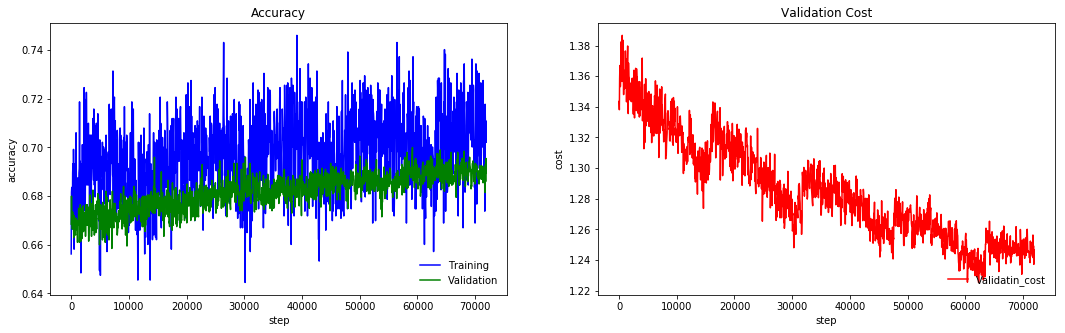

In [18]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(x_range, train_accuracies,'-b', label='Training')
plt.plot(x_range, val_accuracies,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('accuracy')
plt.xlabel('step')
plt.title('Accuracy')

plt.subplot(122)
plt.plot(x_range, val_costs,'-r', label='Validatin_cost')
plt.legend(loc='lower right', frameon=False)
# plt.ylim(ymax = 1.1, ymin = 0.7)
plt.ylabel('cost')
plt.xlabel('step')
plt.title('Validation Cost')
plt.show()

# test 

In [16]:
# restore model
if 'sess' in globals(): sess.close()
sess = tf.InteractiveSession()

ckpt_path = './small_model/small'
saver.restore(sess, ckpt_path+'-79299')

INFO:tensorflow:Restoring parameters from ./small_model/small-79299


In [48]:
%%time
X_fw_test = X_fw_val
X_bw_test = X_bw_val
Xm_test = Xm_val
Xp_test = Xp_val
Y_test = Y_val

Wall time: 0 ns


In [49]:
from math import ceil

# 여기서도 OOM 날수 있다
acc_tot = []
cost_tot = []
cate_predicted = []
chunk_size = 10000 # OOM 방지
iter_num = ceil(len(Y_test)/chunk_size)

for i in range(iter_num):
    test_accuracy, test_cost, tokens = \
        sess.run([accuracy, cost, predicted], feed_dict={X_fw:X_fw_test[chunk_size*i:chunk_size*(i+1)], X_bw:X_bw_test[chunk_size*i:chunk_size*(i+1)], Xm:Xm_test[chunk_size*i:chunk_size*(i+1)], Xp:Xp_test[chunk_size*i:chunk_size*(i+1)], Y:Y_test[chunk_size*i:chunk_size*(i+1)], keep_prob:1, is_training:False})
    acc_tot.append(test_accuracy)
    cost_tot.append(test_cost)
    
    for tok in tokens:
        cate_predicted.append(token_to_cate[tok].split('>'))
    print('Test Accuracy: %g \tTest cost: %g' %(test_accuracy, test_cost))
    
print('Total Accuracy:', np.array(acc_tot).mean(), '\tTotal Cost:', np.array(cost_tot).mean())

Test Accuracy: 0.67 	Test cost: 1.34068
Total Accuracy: 0.67 	Total Cost: 1.3406776


In [50]:
# 분류 계층별 정확도 보기

# 나누기
cate_ans = []
for i in np.argmax(Y_test, axis=1):
    cate_ans.append(token_to_cate[i].split('>'))


cate_predicted = np.array(cate_predicted)
cate_ans = np.array(cate_ans)

# df_cate = pd.DataFrame(cate_predicted, columns=['bcateid', 'mcateid', 'scateid', 'dcateid'])
# 계산하기
cols=['bcateid', 'mcateid', 'scateid', 'dcateid']
aws_list = cate_ans.transpose([1,0]) == cate_predicted.transpose([1,0])
accs = []

for i, aws in enumerate(aws_list):
    _sum = np.sum(aws)
    acc = _sum/len(aws)
    accs.append(acc)
    print('%s: %g \t %d/%d' %(cols[i], acc, _sum, len(aws)))
    
print('final score:', (accs[0]+accs[1]*1.2+accs[2]*1.3+accs[3]*1.4)/4) 
print('아직 결측치 보정은 안함')

bcateid: 0.895 	 1790/2000
mcateid: 0.833 	 1666/2000
scateid: 0.712 	 1424/2000
dcateid: 0.96 	 1920/2000
final score: 1.0410499999999998
아직 결측치 보정은 안함


In [62]:
# 결측치 보정
sid = Counter(df['scateid'])
sratio = (len(df['scateid']) - sid.get(-1))/len(df['scateid'])
np.array(acc_tot).mean()/sratio

0.7073726530058878

---
0.002 --> 0.86 어닐링 없이
 - 최고 정확도

### 할일
- 텐서보드 붙이기
- ~~모델 저장하기~~
- ~~이니셜라이저 사용~~
- 4가지 레이블 맞추기
    - 점수 제작 코드
- ~~대분류당 중분류 중복 안되는지~~
    - 패턴먼저 파악하기
    - 중복 안되면 강제로 CRF적용가능
    - 중복 안됨
- 모듈화
    - myUtils.py 에 정리하기
    
---
데이터가 1,2와 3이 많이 다르네
 - 훈련 지속할 파이프라인 구축이 우선
 - 배치놈 반드시 필요할듯
    